In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import uuid
import cvxpy as cp
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.io import loadmat
import h5py

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Step 1: Define System and Simulation Parameters
N = 64  # Number of BS antennas
K = 4   # Number of users
M = 4   # Number of RF chains
omega = 0.3  # Tradeoff weight
I_max = 120  # Maximum outer iterations
J = 1  # Can be 1, 10, or 20

SNR_dB = 12  # SNR in dB
sigma_n2 = 1  # Noise variance
P_BS = sigma_n2 * 10**(SNR_dB / 10)  # Transmit power
mu = 0.01  # Step size for analog precoder
lambda_ = 0.01  # Step size for digital precoder
L = 20  # Number of paths for channel
num_realizations = 100  # Number of channel realizations

# Dataset parameters
num_channels = 1000
num_epochs = 100 if J == 1 else 30
snr_min, snr_max = 0, 12  # dB

def to_tensor(x, dtype=None, device=device):
    """Convert numpy or tensor input to a torch tensor on the right device."""
    if isinstance(x, torch.Tensor):
        return x.to(device=device, dtype=dtype)
    elif isinstance(x, np.ndarray):
        return torch.as_tensor(x, dtype=dtype, device=device)
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

def to_numpy(x):
    """Convert tensor to numpy array (CPU)"""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise TypeError(f"Unsupported type: {type(x)}")

# Step 2: Define Sensing Parameters
P = 3  # Number of desired sensing angles
theta_d = np.array([-60, 0, 60]) * np.pi / 180  # Desired angles in radians
delta_theta = 5 * np.pi / 180  # Half beamwidth
theta_grid = np.linspace(-np.pi / 2, np.pi / 2, 181)  # Angular grid [-90, 90] degrees
B_d = np.zeros(len(theta_grid))  # Desired beampattern
for t, theta_t in enumerate(theta_grid):
    for theta_p in theta_d:
        if abs(theta_t - theta_p) <= delta_theta:
            B_d[t] = 1

# Wavenumber and antenna spacing
lambda_wave = 1  # Wavelength (normalized)
k = 2 * np.pi / lambda_wave
d = lambda_wave / 2  # Antenna spacing

# Move theta_grid to GPU
theta_grid_gpu = to_tensor(theta_grid, dtype=torch.float32)

# Step 3: Channel Matrix Generation (Saleh-Valenzuela Model)
def generate_channel_batch(N, M, L, batch_size=1, device=device):
    """Generate batch of channels directly on GPU"""
    H = torch.zeros((batch_size, M, N), dtype=torch.cfloat, device=device)
    
    for _ in range(L):
        # Generate complex gains
        alpha_real = torch.randn(batch_size, device=device) / np.sqrt(2)
        alpha_imag = torch.randn(batch_size, device=device) / np.sqrt(2)
        alpha = torch.complex(alpha_real, alpha_imag).reshape(batch_size, 1, 1)
        
        # Random angles
        phi_r = torch.rand(batch_size, device=device) * 2 * np.pi
        phi_t = torch.rand(batch_size, device=device) * 2 * np.pi
        
        # Compute steering vectors
        n_r = torch.arange(M, device=device).float()
        n_t = torch.arange(N, device=device).float()
        
        # Broadcasting for batch computation
        a_r = torch.exp(1j * k * d * n_r.view(1, -1, 1) * torch.sin(phi_r).view(-1, 1, 1)) / np.sqrt(M)
        a_t = torch.exp(1j * k * d * n_t.view(1, 1, -1) * torch.sin(phi_t).view(-1, 1, 1)) / np.sqrt(N)
        
        # Outer product: a_r @ a_t.conj()
        H += np.sqrt(N * M / L) * alpha * torch.bmm(a_r, a_t.conj())
    
    return H.squeeze(0) if batch_size == 1 else H

def generate_channel(N, M, L):
    """Single channel generation (for compatibility)"""
    return generate_channel_batch(N, M, L, batch_size=1, device=device)

# Steering vector function - optimized for GPU
def steering_vector_batch(theta, N, device=device):
    """Compute steering vectors for batch of angles on GPU"""
    n = torch.arange(N, device=device).float()
    if theta.dim() == 0:  # scalar
        theta = theta.unsqueeze(0)
    # theta: (num_angles,), n: (N,)
    return torch.exp(1j * np.pi * n.unsqueeze(0) * torch.sin(theta).unsqueeze(1)) / np.sqrt(N)

def compute_rate(H, A, D, sigma_n2):
    
    H_eff = torch.matmul(H, A)
    coupling_matrix = torch.matmul(H_eff, D)

    signal_power = torch.abs(torch.diagonal(coupling_matrix, dim1=-2, dim2=-1))**2 
    total_rx_power = torch.sum(torch.abs(coupling_matrix)**2, dim=-1) 
    interference_power = total_rx_power - signal_power
    denominator = interference_power + sigma_n2
    SINR = signal_power / denominator 
    xi = 1.0 / np.log(2) 
    rate_k = torch.log(1 + SINR) * xi 
    R = torch.sum(rate_k, dim=-1) 
    return R

# Compute sensing error tau - optimized
def compute_tau(A, D, Psi):
    """Vectorized tau computation"""
    R_realized = torch.matmul(A, torch.matmul(D, torch.matmul(D.mH, A.mH)))
    E = R_realized - Psi
    tau_batch = torch.linalg.norm(E, ord='fro', dim=(-2, -1)) ** 2
    return tau_batch.mean()

def gradient_R_A(H, A, D, sigma_n2):
    """Optimized gradient computation for A"""
    xi = 1.0 / np.log(2)
    grad_A = torch.zeros_like(A)
    
    # Precompute V and V_full
    V = D @ D.conj().T  # (N, N)
    
    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)  # (N, 1)
        H_tilde_k = h_k @ h_k.conj().T  # (N, N)
        
        # Compute V_bar_k more efficiently
        D_bar_k = D.clone()
        D_bar_k[:, k] = 0.0
        V_bar_k = D_bar_k @ D_bar_k.conj().T
        
        # Denominator terms
        AV = A @ V
        AVbar = A @ V_bar_k
        denom1 = torch.trace(AV @ A.conj().T @ H_tilde_k).real + sigma_n2.real
        denom2 = torch.trace(AVbar @ A.conj().T @ H_tilde_k).real + sigma_n2.real
        
        # Gradient contribution
        term1 = H_tilde_k @ AV / denom1
        term2 = H_tilde_k @ AVbar / denom2
        
        grad_A += xi * (term1 - term2)
    
    return grad_A

def gradient_R_D(H, A, D, sigma_n2):
    """Optimized gradient computation for D"""
    xi = 1.0 / np.log(2)
    grad_D = torch.zeros_like(D)
    
    # Precompute A^H
    AH = A.conj().T
    
    for k in range(K):
        h_k = H[k, :].reshape(-1, 1)
        H_tilde_k = h_k @ h_k.conj().T
        H_bar_k = AH @ H_tilde_k @ A  # (M, M)
        
        # Compute D_bar_k more efficiently
        D_bar_k = D.clone()
        D_bar_k[:, k] = 0.0
        DDH = D @ D.conj().T
        DDH_bar = D_bar_k @ D_bar_k.conj().T
        
        # Denominator terms
        denom1 = torch.trace(DDH @ H_bar_k) + sigma_n2
        denom2 = torch.trace(DDH_bar @ H_bar_k) + sigma_n2
        
        # Gradient contributions
        term1 = (H_bar_k @ D) / denom1
        term2 = (H_bar_k @ D_bar_k) / denom2
        
        grad_D += xi * (term1 - term2)
    
    return grad_D


# def gradient_R_D(H, A, D, sigma_n2):
#     xi = 1 / np.log(2)            # Conversion factor from ln() to log2()
#     grad_D = np.zeros_like(D, dtype=complex)

#     # --- Loop over users k ---
#     for k in range(K):
#         # (1) Channel vector for user k
#         h_k = H[k, :].reshape(-1, 1)             # (N x 1)
#         H_tilde_k = h_k @ h_k.conj().T           # (N x N)

#         # (2) Effective digital-domain channel including analog precoder
#         H_bar_k = A.conj().T @ H_tilde_k @ A     # (M x M)

#         # (3) D_bar_k = D with k-th column set to zero
#         D_bar_k = D.clone()
#         D_bar_k[:, k] = 0.0

#         # (4) Compute denominator terms (trace parts)
#         denom1 = np.trace(D @ D.conj().T @ H_bar_k) + sigma_n2
#         denom2 = np.trace(D_bar_k @ D_bar_k.conj().T @ H_bar_k) + sigma_n2

#         # (5) Compute gradient contributions
#         term1 = (H_bar_k @ D) / denom1
#         term2 = (H_bar_k @ D_bar_k) / denom2

#         # (6) Accumulate total gradient
#         grad_D += xi * (term1 - term2)

#     return grad_D

def gradient_tau_A(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_A = 2 * (U - Psi) @ A @ D @ D.conj().T
    return grad_A


def gradient_tau_D(A, D, Psi):
    U = A @ D @ D.conj().T @ A.conj().T   # A D Dᴴ Aᴴ
    grad_D = 2 * A.conj().T @ (U - Psi) @ A @ D
    return grad_D

# Load Psi data and move to GPU
with h5py.File('Psi_all.mat', 'r') as f:

    # Read MATLAB complex dataset properly
    Psi_h5 = f['Psi_all']

    # If it's a compound dtype (MATLAB complex), split real/imag
    if np.issubdtype(Psi_h5.dtype, np.void):
        real = Psi_h5['real'][()]  # convert to numpy array
        imag = Psi_h5['imag'][()]
        Psi_all = real + 1j*imag
    else:
        Psi_all = np.array(Psi_h5)

    SNR_dB = np.array(f['SNR_dB']).flatten()
    
    # Move to GPU
    Psi_all_gpu = to_tensor(Psi_all, dtype=torch.cfloat)
    SNR_dB_tensor = to_tensor(SNR_dB, dtype=torch.float32)

def compute_psi(snr_db):
    """Compute Psi on GPU"""
    idx = torch.argmin(torch.abs(SNR_dB_tensor - snr_db))
    Psi = Psi_all_gpu[idx, :, :]
    return Psi

def project_unit_modulus(A):
    """Fast unit modulus projection"""
    return torch.exp(1j * torch.angle(A))

def project_power_constraint(A, D, P_BS):
    """Fast power constraint projection"""
    norm_factor = torch.linalg.norm(A @ D, ord='fro')
    D = D * (torch.sqrt(P_BS) / norm_factor)
    return D

def proposed_initialization(H, theta_d, N, M, K, P_BS):
    """Initialization - done on GPU"""
    # Convert to numpy for pinv operations (more stable)
    H_np = to_numpy(H)
    G = np.array([H_np[k, :] for k in range(K)]).T
    A0 = np.exp(1j * np.angle(G))
    X_ZF = np.linalg.pinv(H_np)
    D0 = np.linalg.pinv(A0) @ X_ZF
    D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')

    
    # Move back to GPU
    return to_tensor(A0, dtype=torch.cfloat), to_tensor(D0, dtype=torch.cfloat)

class UPGANetLayer(nn.Module):
    def __init__(self, N, M, K, omega, J=10, eta=None):
        super(UPGANetLayer, self).__init__()
        self.J = J
        self.N, self.M, self.K = N, M, K
        self.omega = omega
        self.eta = eta if eta is not None else 1/N

        # Learnable step sizes
        self.mu = nn.Parameter(torch.full((J,), 0.001, dtype=torch.float32))
        self.lambda_ = nn.Parameter(torch.tensor(0.001, dtype=torch.float32))

    def forward(self, H, A, D, Psi, sigma_n2, P_BS):

        # J inner updates for analog precoder
        for j in range(self.J):
            grad_RA = gradient_R_A(H, A, D, sigma_n2)
            grad_tauA = gradient_tau_A(A, D, Psi)

            if torch.isnan(grad_RA).any() or torch.isnan(grad_tauA).any():
                # print(f"NaN detected in gradients at inner iter {j}, skipping update.")
                continue

            A = A + self.mu[j] * (grad_RA - self.omega * grad_tauA)
            A = project_unit_modulus(A)

        # Digital precoder update
        grad_RD = gradient_R_D(H, A, D, sigma_n2)
        grad_tauD = gradient_tau_D(A, D, Psi)

        D = D + self.lambda_ * (grad_RD - self.omega * self.eta * grad_tauD)
        D = project_power_constraint(A, D, P_BS)

        return A, D


class UPGANet(nn.Module):
    def __init__(self, N, M, K, omega, I_max=120, J=10):
        super(UPGANet, self).__init__()
        self.layers = nn.ModuleList([
            UPGANetLayer(N, M, K, omega, J=J) for _ in range(I_max)
        ])
        self.I_max = I_max
        self.omega = omega
    
    def forward(self, H, A0, D0, Psi, sigma_n2, P_BS):
        A, D = A0, D0
        for i in range(self.I_max):
            A, D = self.layers[i](H, A, D, Psi, sigma_n2, P_BS)
        return A, D

def upganet_loss(H, A, D, Psi, sigma_n2, omega, theta_grid_gpu):
    """Loss computation using GPU theta_grid"""
    R = compute_rate(H, A, D, sigma_n2)
    tau = compute_tau(A, D, Psi)
    return -(R - omega * tau)

# Training loop

loss_history = []
mu_history = []
lambda_history = []

J_values = [1]
H = generate_channel_batch(N, M, L=20, batch_size=num_channels, device=device)
for J in J_values:
    print(f"\n=== Training with J = {J} ===")
    
    # Move model to GPU
    model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Pre-generate SNR values on GPU
    snr_values = torch.arange(snr_min, snr_max, 0.1, device=device)
    for epoch in range(num_epochs):
        total_loss = 0.0

        for ch_idx in range(num_channels):
            # Select channel and change dimensions
            H_ch = H[ch_idx, :, :]  # (M, N)     # 1ms
            # H_ch = generate_channel(N, M, 20)      # 5ms
            
            # Random SNR
            snr_db = snr_values[torch.randint(len(snr_values), (1,), device=device)].item()
            
            # Get Psi on GPU
            Psi = compute_psi(snr_db)

            P_BS = sigma_n2 * 10**(snr_db / 10)
            
            # Initialization on GPU
            A0, D0 = proposed_initialization(H_ch, theta_d, N, M, K, P_BS)

            
            # Convert scalars to tensors on GPU
            sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
            P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
            
            # Forward pass
            A_final, D_final = model(H_ch, A0, D0, Psi, sigma_n2_t, P_BS_t)

            
            # Compute loss
            loss = upganet_loss(H_ch, A_final, D_final, Psi, sigma_n2_t, omega, theta_grid_gpu)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            
            if (ch_idx + 1) % 100 == 0:
                print(f"Channel {ch_idx+1}/{num_channels} processed.")
        
        avg_loss = total_loss / num_channels
        print(f"[Epoch {epoch+1}/{num_epochs}] Average Loss: {avg_loss:.6f}")

        loss_history.append(avg_loss)

        # Log mu and lambda (if they exist)
        with torch.no_grad():
            mu_val = model.mu.item() if hasattr(model, 'mu') else None
            lambda_val = model.lambda_.item() if hasattr(model, 'lambda_') else None
            mu_history.append(mu_val)
            lambda_history.append(lambda_val)
        
        # Clear CUDA cache periodically
        if (epoch + 1) % 10 == 0:
            torch.cuda.empty_cache()

print("\nTraining completed!")

Using device: cpu

=== Training with J = 1 ===
Channel 100/1000 processed.


KeyboardInterrupt: 

Size of G: (64, 4, 4)
Size of H: (100, 4, 64)


In [97]:
# Create a folder to store checkpoints if it doesn’t exist
import os
os.makedirs("checkpoints", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), f"checkpoints/upganet_J{J}_final.pth")
print(f"Model saved successfully: checkpoints/upganet_J{J}_final.pth")


Model saved successfully: checkpoints/upganet_J1_final.pth


In [98]:
model = UPGANet(N, M, K, omega, I_max=I_max, J=J).to(device)
model.load_state_dict(torch.load(f"checkpoints/upganet_J{J}_final.pth"))
model.eval() 

UPGANet(
  (layers): ModuleList(
    (0-39): 40 x UPGANetLayer()
  )
)

/tmp/ipykernel_1395319/3130226855.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)
/tmp/ipykernel_1395319/3712294120.py:292: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  D0 = np.sqrt(P_BS) * D0 / np.linalg.norm(A0 @ D0, 'fro')


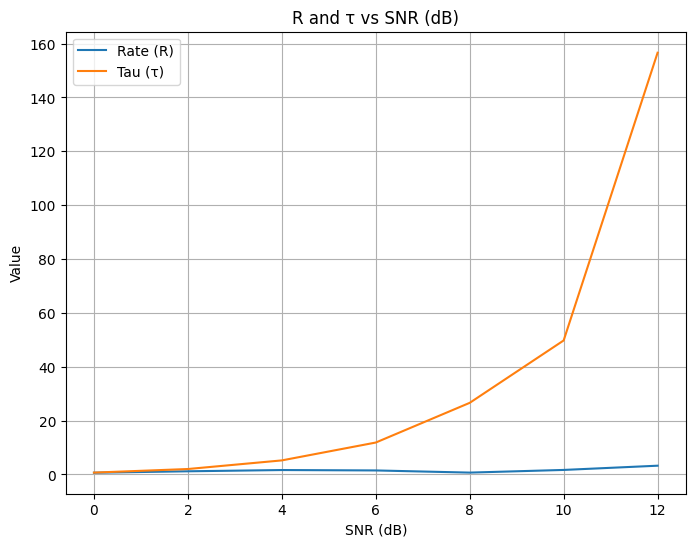

In [100]:
import torch
import matplotlib.pyplot as plt

# Ensure evaluation mode
model.eval()

# Prepare SNR range (same as training)
snr_values = torch.arange(snr_min, snr_max+1, 2, device=device)

R_list = []
tau_list = []

# No gradient computation needed in eval mode
with torch.no_grad():
    for snr_db in snr_values:
        # Generate channel (same as during training)
        H_ch = generate_channel(N, M, 20).to(device)

        # Compute Psi and other quantities
        Psi = compute_psi(snr_db)
        sigma_n2_t = torch.tensor(sigma_n2, dtype=torch.float32, device=device)
        P_BS = sigma_n2 * 10**(snr_db / 10)
        P_BS_t = torch.tensor(P_BS, dtype=torch.float32, device=device)

        # Initialize A0, D0 (same as training)
        A0, D0 = proposed_initialization(H_ch, theta_d, N, M, K, P_BS)

        # Forward pass
        A_final, D_final = model(H_ch, A0, D0, Psi, sigma_n2_t, P_BS_t)

        # Compute R and tau directly
        R_val = compute_rate(H_ch, A_final, D_final, sigma_n2_t)
        tau_val = compute_tau(A_final, D_final, Psi)

        # Store results
        R_list.append(R_val.item())
        tau_list.append(tau_val.item())

# Move to CPU for plotting
snr_cpu = snr_values.detach().cpu().numpy()
R_cpu = torch.tensor(R_list).cpu().numpy()
tau_cpu = torch.tensor(tau_list).cpu().numpy()

# Plot
plt.figure(figsize=(8,6))
plt.plot(snr_cpu, R_cpu, label='Rate (R)')
plt.plot(snr_cpu, tau_cpu, label='Tau (τ)')
plt.xlabel('SNR (dB)')
plt.ylabel('Value')
plt.title('R and τ vs SNR (dB)')
plt.grid(True)
plt.legend()
plt.show()

